# **Importing the required packages**

In [24]:
from datasets import load_dataset
from datasets import DatasetDict
import pandas as pd
from transformers import AutoTokenizer
from transformers import AutoModel
import pickle
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# ***Data Exploration***

Firstly we load all data into pandas DataFrame to plot classes distribution in the dataset.

In [15]:
df = pd.read_csv("IMDB_Dataset.csv")

In [16]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


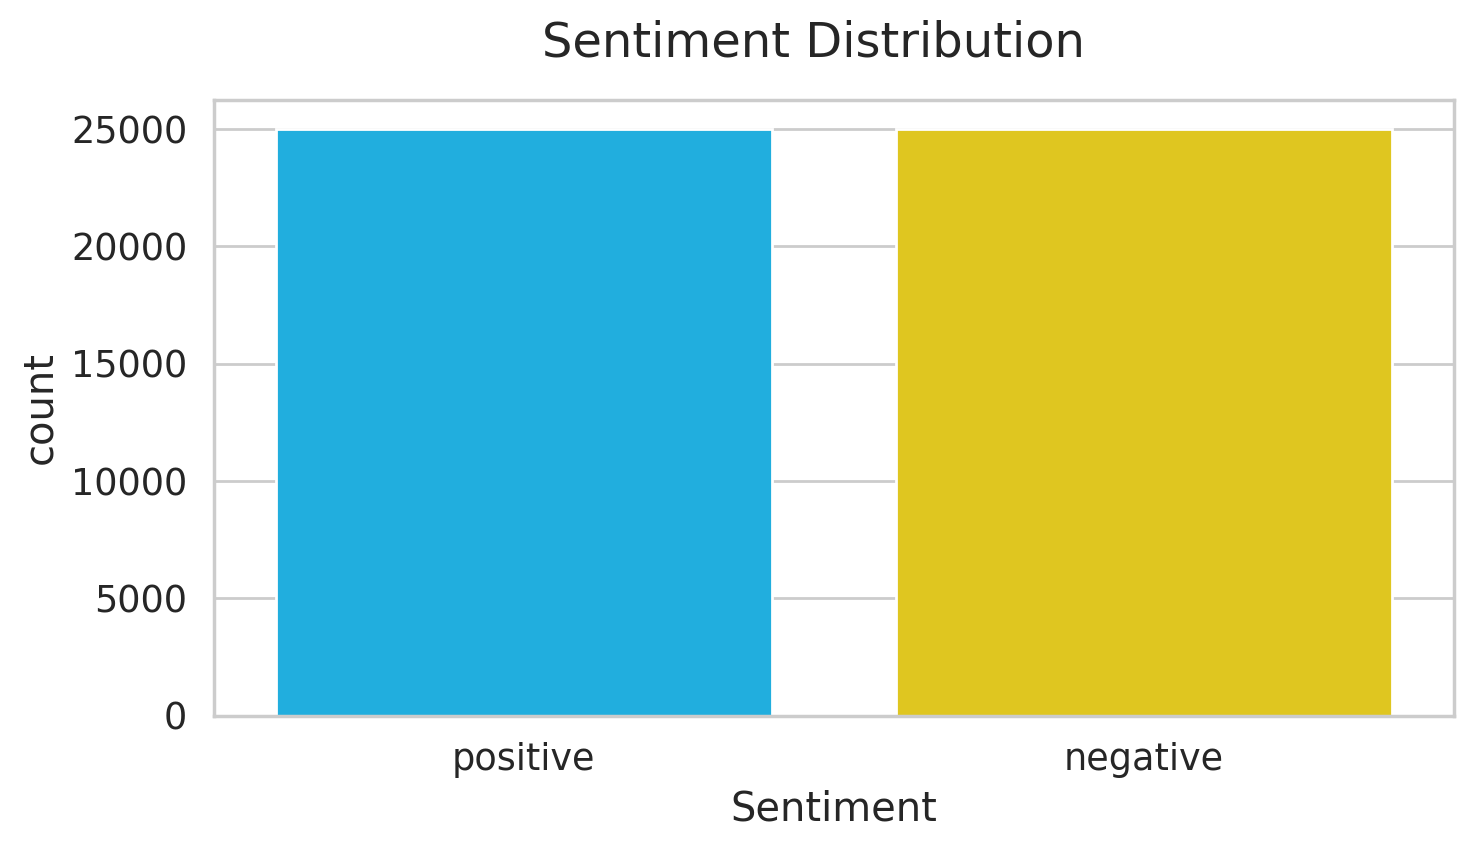

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(data=df, x="sentiment", orient="v", hue="sentiment", ax=ax)
ax.set_xlabel('Sentiment')
fig.suptitle('Sentiment Distribution')
plt.show()

### Preparing HuggingFace Dataset object

Loading data using Hugging Face `Datasets` and splitting to training, validation and test sets.

In [12]:
ds = load_dataset("csv", data_files="IMDB_Dataset.csv")
ds = ds.class_encode_column("sentiment")
train_testvalid = ds['train'].train_test_split(test_size=0.3, stratify_by_column="sentiment")
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, stratify_by_column="sentiment")
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [13]:
ds

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 7500
    })
    valid: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 7500
    })
})

#### Example from the dataset

In [20]:
ds['train'][5]

{'review': "Tycoon will never be listed as one of John Wayne's better post Stagecoach film. It's good in spots, has some fine action sequences in the cave in and also in the flood at the climax. But the plot leaves a lot to be desired.<br /><br />What we have in Tycoon is two men who thoroughly dislike each other and that dislike prevents them from working as a team. Multimillionaire Cedric Hardwicke has hired John Wayne and James Gleason to build a railroad. But then he refuses to give them the needed funds to do the job right.<br /><br />Things get really complicated when Wayne falls for Hardwicke's daughter, Laraine Day. After a night when they have to spend time alone in an Inca ruin, by convention in South America, Wayne and Day get a shotgun wedding even though nothing happened.<br /><br />What should have happened is these two should have been locked in a room for 24 hours together to work out their differences one way or another. Their petty spites cause some fatalities among W

## Data Preprocessing

There is need for preprocessing. Sentences as strings cannot be feeded to transformer directly. Sentences must be splitted to tokens and transformed to numerical representation. Also sentences must be truncated to a given length, padded and masked.

We chose pretrained `bert-base-cased` model which available in the huggingface transformers package. Important information about this transformer is that it accept only maximum 512 tokens as input.

In [21]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Loading a pre-trained BertTokenizer

In [22]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

As model accept only 512 tokens, there is a need to set cutoff level for sequences. Firstly, let's have an look on sequences length (in tokens) distribution.

In [29]:
# df object is a DataFrame which inlude all available data.
# Cell produces warnings, as there is truncation turned off purposely.

token_lens = []
token_sents = []

for txt, sent in zip(df.review, df.sentiment):
    tokens = tokenizer.encode(txt, truncation=False)
    token_lens.append(len(tokens))
    token_sents.append(sent)

seq_lens = pd.DataFrame({"lens": token_lens, "sents": token_sents})

In [14]:
## How looks plot below in the context of sentiment classes?!

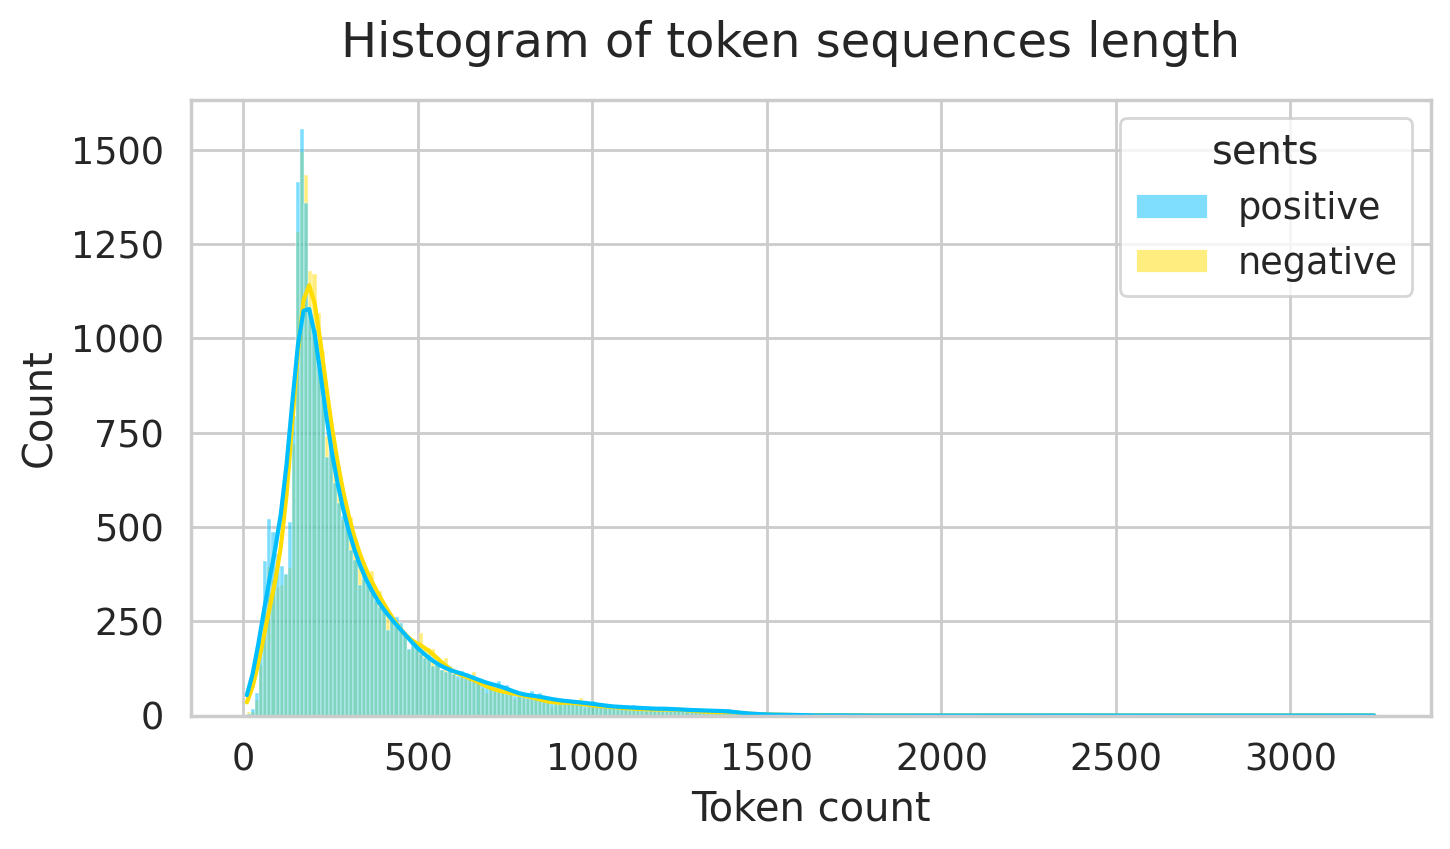

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(data=seq_lens, x="lens", hue="sents", kde=True, ax=ax)
#plt.xlim([0, 1000])
ax.set_xlabel('Token count')
fig.suptitle("Histogram of token sequences length")
plt.show()

**Results**  
It is clear that:
* length distribution of produced by BERT tokenizer token sequences are very similar for both classes. My hypothesis about more engaged haters is not supported ;(
* token sequence length is not normally distributed. There is a very long tail.

BERT model accept only context of maximum 512 tokens, so sequences have to be truncated. As  clearly there is a lot of sequences longer than 512 tokens, I will utilized maximum number of tokens: 512.

In [33]:
MAX_LEN = 512

# Feature Extraction

In [6]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

#### Setting up BERT tokenizer

In [7]:
tokenizer=AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [8]:
tokenizer.vocab_size

28996

##### Fun with the tokenizer

In [40]:
text = "Tycoon will never be listed as one of John Wayne's better post Stagecoach film."
encoded_text = tokenizer(text)
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

In [39]:
encoded_text

{'input_ids': [101, 5331, 18201, 1209, 1309, 1129, 2345, 1112, 1141, 1104, 1287, 5489, 112, 188, 1618, 2112, 6160, 26851, 1273, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [44]:
print(tokens)

['[CLS]', 'Ty', '##coon', 'will', 'never', 'be', 'listed', 'as', 'one', 'of', 'John', 'Wayne', "'", 's', 'better', 'post', 'Stage', '##coach', 'film', '.', '[SEP]']


Of course it is possible to synthesize initial `text` from the tokens sequence.

In [45]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] Tycoon will never be listed as one of John Wayne ' s better post Stagecoach film. [SEP]


#### Setting up BERT model

In [9]:
model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)

In [10]:
# Input for the model:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

#### Feature extraction

In [11]:
def tokenize(batch):
    return tokenizer(batch["review"], padding=True, truncation=True)

In [14]:
ds_encoded = ds.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [15]:
print(ds_encoded["train"].column_names)

['review', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask']


In [16]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU:
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states:
    with torch.no_grad():
        pooler_state = model(**inputs).pooler_output
    return {"pooler_state": pooler_state.cpu().numpy()}

In [17]:
ds_encoded.set_format("torch", columns=["input_ids", "attention_mask", "token_type_ids", "sentiment"])

In [18]:
ds_hidden = ds_encoded.map(extract_hidden_states, batched=True, batch_size=100)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [19]:
ds_hidden["train"].column_names

['review',
 'sentiment',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'pooler_state']

In [26]:
with open("results/BERT_ds_hidden.pkl", "wb") as file:
    pickle.dump(ds_hidden, file)

#### Creating a feature matrix

Extracted hidden states of the CLS token will be used for a downstream classifier.

In [5]:
with open("results/BERT_ds_hidden.pkl", "rb") as file:
    ds_hidden = pickle.load(file)

In [19]:
X_train = np.array(ds_hidden["train"]["pooler_state"])
X_valid = np.array(ds_hidden["valid"]["pooler_state"])
X_test = np.array(ds_hidden["test"]["pooler_state"])

y_train = np.array(ds_hidden["train"]["sentiment"])
y_valid = np.array(ds_hidden["valid"]["sentiment"])
y_test = np.array(ds_hidden["test"]["sentiment"])

In [20]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(35000, 768)
(7500, 768)
(7500, 768)


# Dimensionality Reduction

As UMAP works better when features are rescaled to [0, 1] range, firstly I apply `MinMaxScaler` class from the sklearn library.

In [36]:
X_scaled = MinMaxScaler().fit_transform(X_train)

After that we can initialize and fit UMAP.

In [38]:
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

Then I create DataFrame of 2D embeddings.

In [39]:
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,6.745865,3.928154,1
1,10.365879,5.254757,1
2,5.905606,7.271180,1
3,-2.309240,6.404212,1
4,1.631191,1.334721,0


#### Visualization of examples in 2 dimensional space.

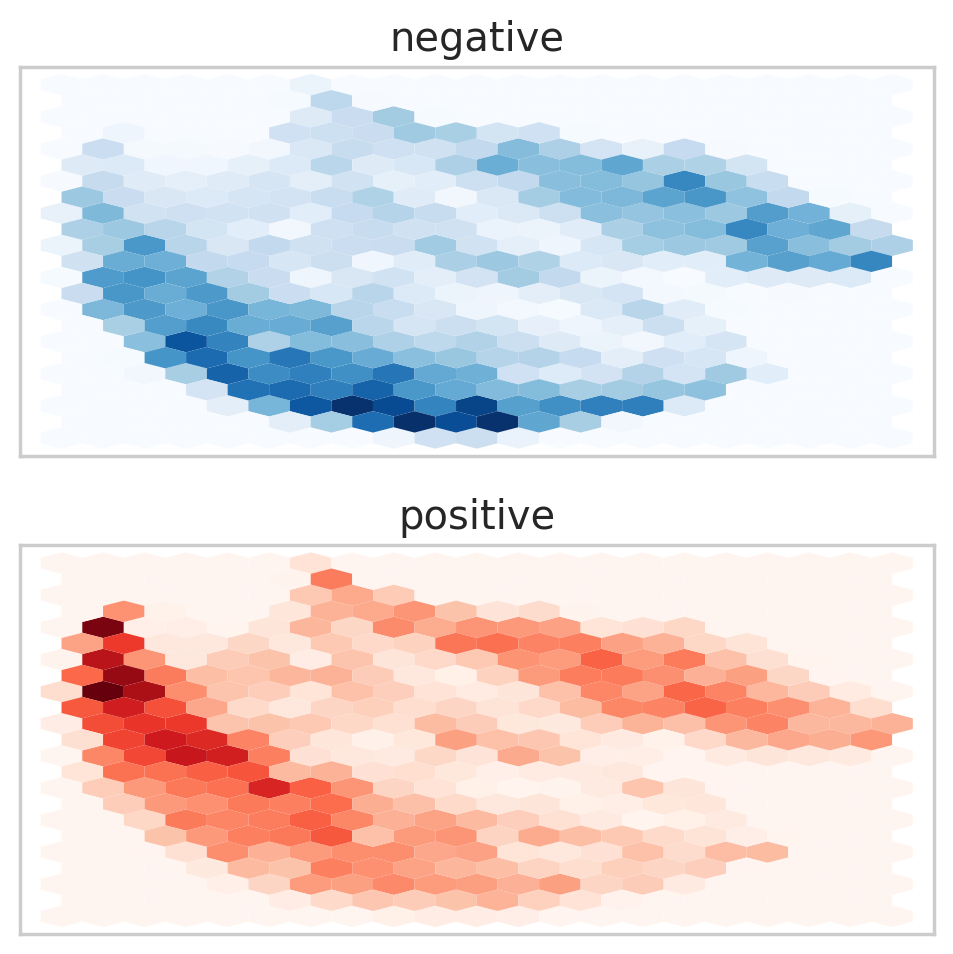

In [44]:
fig, axes = plt.subplots(2, figsize=(5,5))
cmaps = ["Blues", "Reds"]
labels = ["negative", "positive"]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

# Training of the final classifier

### Dummy Classifier - baseline

In [51]:
from sklearn.dummy import DummyClassifier

In [52]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.5001333333333333

## Linear models

### Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression

In [48]:
lr_clf = LogisticRegression(max_iter=3000)

lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.8193333333333334

### Linear Discriminant Analysis (LDA)

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [12]:
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)
lda_clf.score(X_valid, y_valid)

0.8041333333333334

### SVM classifier - linear kernel

In [8]:
from sklearn.svm import SVC

In [9]:
lsvm_clf = SVC(kernel='linear')
lsvm_clf.fit(X_train, y_train)
lsvm_clf.score(X_valid, y_valid)

0.8224

### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
rf_clf = RandomForestClassifier(n_estimators=150,
                                max_depth=15,    
                               )
rf_clf.fit(X_train, y_train)
rf_clf.score(X_valid, y_valid)

0.76

### XGB Classifier

In [9]:
from xgboost import XGBClassifier

In [10]:
XGB_clf = XGBClassifier(random_state=42,
                          n_estimators=150,
                          max_depth=15,
                          booster='gbtree')
XGB_clf.fit(X_train, y_train)
XGB_clf.score(X_valid, y_valid)

0.7878666666666667

### SVM Classifier - RBF kernel

In [18]:
nlsvm_clf = SVC(kernel='rbf')
nlsvm_clf.fit(X_train, y_train)
nlsvm_clf.score(X_valid, y_valid)

0.7733333333333333

#### Confusion matrix for a SVM classifier on TEST set

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [17]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(4,4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

#### Results of the linear SVM classifier on the test set

In [21]:
lsvm_clf.score(X_test, y_test)

0.8257333333333333

#### Confusion matrix

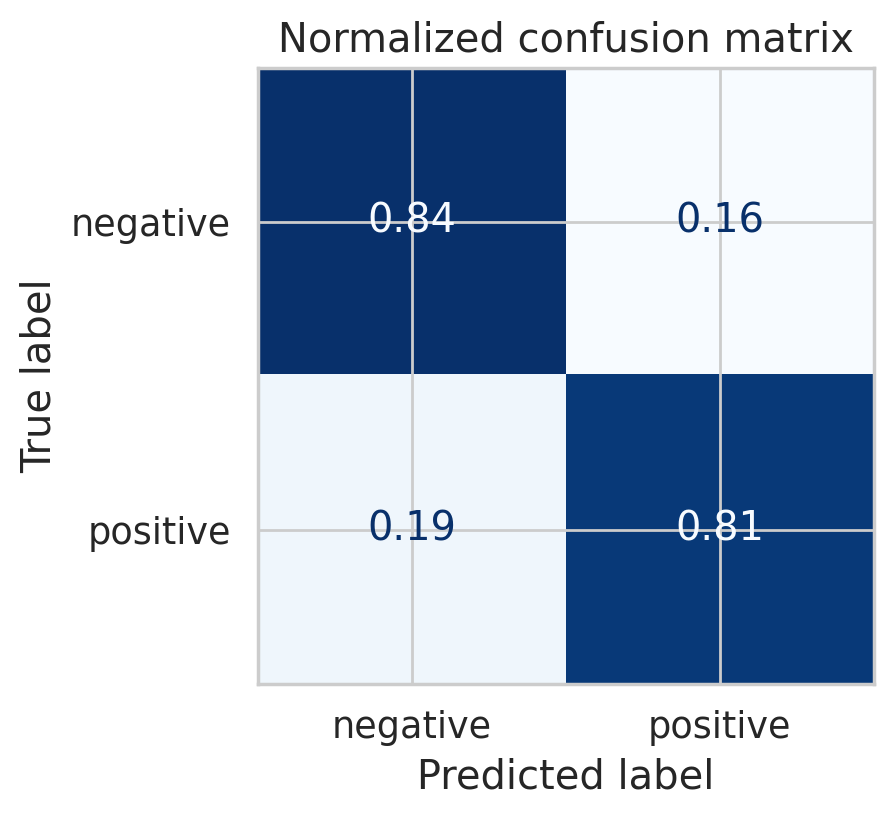

In [22]:
labels = ["negative", "positive"]
y_preds = lsvm_clf.predict(X_test)
plot_confusion_matrix(y_preds, y_test, labels)